# Predispatch Price Convergence in 2021

In this example, we will take a look at (30-minute) pre-dispatch ({term}`PREDISPATCH`) energy price convergence. 

In AEMO data tables, the energy price in \$/MW/hr is usually found in the `RRP` column.

We will focus on 5-minute dispatch interval prices. 

```{note}
Prior to midnight 30 September (commencement of 5-minute settlement), market settlement prices for energy were calculated as the average of the 6 dispatch interval prices in a half hour window.
```

## Library Imports

In [134]:
# standard libraries
import logging
import multiprocessing as mp
from datetime import datetime, timedelta
from pathlib import Path
from typing import Tuple

# NEM data libraries
# NEMOSIS for actual demand data
# NEMSEER for forecast demand data
import nemosis
from nemseer import compile_data, download_raw_data, generate_runtimes

# data wrangling libraries
import numpy as np
import pandas as pd
import xarray as xr

# interactive plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# progress bar for error computation
from tqdm.notebook import tqdm

# silence NEMSEER and NEMOSIS logging
logging.getLogger("nemosis").setLevel(logging.WARNING)
logging.getLogger("nemseer").setLevel(logging.ERROR)

## Defining our analysis start and end dates

In [2]:
analysis_start = "2021/01/01 00:00:00"
analysis_end = "2022/01/01 00:00:00"

## Getting Data

### Obtaining actual price data from `NEMOSIS`

We will download `DISPATCHPRICE` to access the `RRP` (energy price) field.

We'll first download the data we need and cache it so that it's ready for computation.

In [3]:
nemosis_cache = Path("nemosis_cache/")
if not nemosis_cache.exists():
    nemosis_cache.mkdir()

In [4]:
nemosis.cache_compiler(
    analysis_start, analysis_end, "DISPATCHPRICE", nemosis_cache, fformat="parquet"
)

### Obtaining actual demand data from `NEMOSIS`

We can download `DISPATCHREGIONSUM` to get actual demand data (`TOTALDEMAND`). 

We'll only use this for plotting.

In [5]:
nemosis.cache_compiler(
    analysis_start, analysis_end, "DISPATCHREGIONSUM", nemosis_cache, fformat="parquet"
)

### Obtaining forecast price data from `NEMSEER`

We will download `PRICE` to access the `RRP` field in `PREDISPATCH` forecasts, and `REGIONSOLUTION` to access the `RRP` field in `P5MIN` forecasts.

We'll first download the data we need and cache it so that it's ready for computation.

In [6]:
download_raw_data(
    "PREDISPATCH",
    "PRICE",
    "nemseer_cache/",
    forecasted_start=analysis_start,
    forecasted_end=analysis_end,
)


download_raw_data(
    "P5MIN",
    "REGIONSOLUTION",
    "nemseer_cache/",
    forecasted_start=analysis_start,
    forecasted_end=analysis_end,
)

### Obtaining forecast demand data from NEMSEER

For plotting, we will also download demand data. 

This is contained within `REGIONSOLUTION` for `P5MIN`, but we need to get the table `REGIONSUM` for `PREDISPATCH`.

In [7]:
download_raw_data(
    "PREDISPATCH",
    "REGIONSUM",
    "nemseer_cache/",
    forecasted_start=analysis_start,
    forecasted_end=analysis_end,
)

## Comparing price (and demand) convergence for a particular time

The code below allows us to plot forecast convergence for price and demand across PD and P5.

Note that we adjust the *nominal* {term}`run time` to the {term}`actual run time`.

In [8]:
def plot_price_comparison(time: str, regionid: str) -> go.Figure:
    """
    Creates a figure that compares price forecasts from PD & P5MIN against
    the actual price.

    Args:
        time: Datetime string in format YYYY/mm/dd HH:MM:SS
        regionid: One of ("NSW1", "QLD1", "VIC1", "TAS1", "SA1")
    Returns:
        plotly Figure
    """

    def get_actual_data(time: str) -> pd.DataFrame:
        """
        Gets actual price data
        """
        # get actual data from the hour beforehand to the interval of interest
        nemosis_window = (
            (
                datetime.strptime(time, "%Y/%m/%d %H:%M:%S") - timedelta(minutes=60)
            ).strftime("%Y/%m/%d %H:%M:%S"),
            time,
        )
        nemosis_price = nemosis.dynamic_data_compiler(
            nemosis_window[0],
            nemosis_window[1],
            "DISPATCHPRICE",
            nemosis_cache,
            filter_cols=["INTERVENTION"],
            filter_values=([0],),
        )
        actual_price = nemosis_price[["SETTLEMENTDATE", "REGIONID", "RRP"]]
        return actual_price

    def get_forecast_data(time: str) -> Tuple[xr.DataArray, xr.DataArray]:
        """
        Gets P5 and PD forecast price data
        Also corrects nominal to actual run time
        """
        # get P5 and PD forecast data
        ## get PD data
        run_start, run_end = generate_runtimes(time, time, "PREDISPATCH")
        pd_price = compile_data(
            run_start,
            run_end,
            time,
            time,
            "PREDISPATCH",
            "PRICE",
            "nemseer_cache/",
            data_format="xr",
        )["PRICE"]["RRP"]
        ## calculate actual run time from run time, then swap out nominal for actual
        pd_price = pd_price.assign_coords(
            {"actual_run_time": pd_price.coords["run_time"] - pd.Timedelta(30, "T")}
        )
        pd_price = pd_price.swap_dims({"run_time": "actual_run_time"}).drop("run_time")
        ## get P5 data
        p5_price = compile_data(
            run_start,
            run_end,
            time,
            time,
            "P5MIN",
            "REGIONSOLUTION",
            "nemseer_cache/",
            data_format="xr",
        )["REGIONSOLUTION"]["RRP"]
        ## calculate actual run time from run time, then swap out nominal for actual
        p5_price = p5_price.assign_coords(
            {"actual_run_time": p5_price.coords["run_time"] - pd.Timedelta(5, "T")}
        )
        p5_price = p5_price.swap_dims({"run_time": "actual_run_time"}).drop("run_time")
        return pd_price, p5_price

    actual_price = get_actual_data(time).query("REGIONID==@regionid")
    pd_price, p5_price = get_forecast_data(time)
    pd_price = pd_price.sel(REGIONID=regionid)
    p5_price = p5_price.sel(REGIONID=regionid)
    # create plotly figure
    fig = go.Figure(
        layout=dict(
            title=f"Energy Price Comparison: {regionid} {time} <br><sup>Actual run times for forecasts</sup>"
        )
    )
    fig.add_traces(
        [
            go.Scatter(
                x=pd_price.isel(forecasted_time=0).to_dataframe().index,
                y=pd_price.isel(forecasted_time=0).to_dataframe()["RRP"],
                name="PD",
                mode="lines",
            ),
            go.Scatter(
                x=p5_price.isel(forecasted_time=0).to_dataframe().index,
                y=p5_price.isel(forecasted_time=0).to_dataframe()["RRP"],
                name="P5",
                mode="lines",
            ),
            go.Scatter(
                x=actual_price["SETTLEMENTDATE"],
                y=actual_price["RRP"],
                mode="lines",
                name="actual",
            ),
        ]
    )
    return fig

In [9]:
def plot_demand_comparison(time: str, regionid: str) -> go.Figure:
    """
    Creates a figure that compares demand forecasts from PD & P5MIN against
    the actual demand used in dispatch.

    Args:
        time: Datetime string in format YYYY/mm/dd HH:MM:SS
        regionid: One of ("NSW1", "QLD1", "VIC1", "TAS1", "SA1")
    Returns:
        plotly Figure
    """

    def get_actual_data(time: str) -> pd.DataFrame:
        """
        Gets actual demand data
        """
        # get actual data from the hour beforehand to the interval of interest
        nemosis_window = (
            (
                datetime.strptime(time, "%Y/%m/%d %H:%M:%S") - timedelta(minutes=60)
            ).strftime("%Y/%m/%d %H:%M:%S"),
            time,
        )
        nemosis_demand = nemosis.dynamic_data_compiler(
            nemosis_window[0],
            nemosis_window[1],
            "DISPATCHREGIONSUM",
            nemosis_cache,
            filter_cols=["INTERVENTION"],
            filter_values=([0],),
        )
        actual_demand = nemosis_demand[["SETTLEMENTDATE", "REGIONID", "TOTALDEMAND"]]
        return actual_demand.sort_values("SETTLEMENTDATE")

    def get_forecast_data(time: str) -> Tuple[xr.DataArray, xr.DataArray]:
        """
        Gets P5 and PD forecast demand data
        Also corrects nominal to actual run time
        """
        # get P5 and PD forecast data
        ## get PD data
        run_start, run_end = generate_runtimes(time, time, "PREDISPATCH")
        pd_demand = compile_data(
            run_start,
            run_end,
            time,
            time,
            "PREDISPATCH",
            "REGIONSUM",
            "nemseer_cache/",
            data_format="xr",
        )["REGIONSUM"]["TOTALDEMAND"]
        ## calculate actual run time from run time, then swap out nominal for actual
        pd_demand = pd_demand.assign_coords(
            {"actual_run_time": pd_demand.coords["run_time"] - pd.Timedelta(30, "T")}
        )
        pd_demand = pd_demand.swap_dims({"run_time": "actual_run_time"}).drop(
            "run_time"
        )
        ## get P5 data
        p5_demand = compile_data(
            run_start,
            run_end,
            time,
            time,
            "P5MIN",
            "REGIONSOLUTION",
            "nemseer_cache/",
            data_format="xr",
        )["REGIONSOLUTION"]["TOTALDEMAND"]
        ## calculate actual run time from run time, then swap out nominal for actual
        p5_demand = p5_demand.assign_coords(
            {"actual_run_time": p5_demand.coords["run_time"] - pd.Timedelta(5, "T")}
        )
        p5_demand = p5_demand.swap_dims({"run_time": "actual_run_time"}).drop(
            "run_time"
        )
        return pd_demand, p5_demand

    actual_demand = get_actual_data(time).query("REGIONID==@regionid")
    pd_demand, p5_demand = get_forecast_data(time)
    pd_demand = pd_demand.sel(REGIONID=regionid)
    p5_demand = p5_demand.sel(REGIONID=regionid)
    # create plotly figure
    fig = go.Figure(
        layout=dict(
            title=f"Demand Comparison: {regionid} {time} <br><sup>Actual run times for forecasts</sup>"
        )
    )
    fig.add_traces(
        [
            go.Scatter(
                x=pd_demand.isel(forecasted_time=0).to_dataframe().index,
                y=pd_demand.isel(forecasted_time=0).to_dataframe()["TOTALDEMAND"],
                name="PD",
                mode="lines",
            ),
            go.Scatter(
                x=p5_demand.isel(forecasted_time=0).to_dataframe().index,
                y=p5_demand.isel(forecasted_time=0).to_dataframe()["TOTALDEMAND"],
                name="P5",
                mode="lines",
            ),
            go.Scatter(
                x=actual_demand["SETTLEMENTDATE"],
                y=actual_demand["TOTALDEMAND"],
                mode="lines",
                name="actual",
            ),
        ]
    )
    return fig

Let's pick a summer's evening ramp.

In [10]:
time = "2021/12/30 18:00:00"
price_comp = plot_price_comparison(time, "NSW1")
demand_comp = plot_demand_comparison(time, "NSW1")

In [11]:
pio.write_html(price_comp, "../_static/price_cov.html")

```{raw} html
---
file: ../_static/price_cov.html
---
```

In [12]:
pio.write_html(demand_comp, "../_static/demand_cov.html")

```{raw} html
---
file: ../_static/demand_cov.html
---
```

## Looking at price convergence a bit more systematically

In [80]:
def get_actual_price_data() -> pd.DataFrame:
    """
    Gets actual price data
    """
    # get actual demand data for forecasted_time
    # nemosis start time must precede end of interval of interest by 5 minutes
    nemosis_window = (
        (
            datetime.strptime(analysis_start, "%Y/%m/%d %H:%M:%S")
            - timedelta(minutes=5)
        ).strftime("%Y/%m/%d %H:%M:%S"),
        analysis_end,
    )
    nemosis_price = nemosis.dynamic_data_compiler(
        nemosis_window[0],
        nemosis_window[1],
        "DISPATCHPRICE",
        nemosis_cache,
        filter_cols=["INTERVENTION"],
        filter_values=([0],),
    )
    actual_price = nemosis_price[["SETTLEMENTDATE", "REGIONID", "RRP"]]
    actual_price = actual_price.rename(columns={"SETTLEMENTDATE": "forecasted_time"})
    return actual_price

In [81]:
def get_forecast_price_data(ftype: str) -> pd.DataFrame:
    """
    Get price forecast data for the analysis period given a particular forecast type

    Args:
        ftype: 'P5MIN' or 'PREDISPATCH'
    Returns:
        DataFrame with price forecast data
    """
    # ftype mappings
    table = {"PREDISPATCH": "PRICE", "P5MIN": "REGIONSOLUTION"}
    run_col = {"PREDISPATCH": "PREDISPATCH_RUN_DATETIME", "P5MIN": "RUN_DATETIME"}
    forecasted_col = {"PREDISPATCH": "DATETIME", "P5MIN": "INTERVAL_DATETIME"}
    # get run times
    forecasts_run_start, forecasts_run_end = generate_runtimes(
        analysis_start, analysis_end, ftype
    )
    df = compile_data(
        forecasts_run_start,
        forecasts_run_end,
        analysis_start,
        analysis_end,
        ftype,
        table[ftype],
        "nemseer_cache/",
    )[table[ftype]]
    # remove intervention periods
    df = df.query("INTERVENTION == 0")
    # rename run and forecasted time cols
    df = df.rename(
        columns={run_col[ftype]: "run_time", forecasted_col[ftype]: "forecasted_time"}
    )
    # ensure values are sorted by forecasted and run times for future nth operation
    return df[["run_time", "forecasted_time", "REGIONID", "RRP"]].sort_values(
        ["forecasted_time", "run_time"]
    )

In [82]:
p5_df = get_forecast_price_data("P5MIN")
pd_df = get_forecast_price_data("PREDISPATCH")
# calulate actual run time for each forecast type
p5_df["actual_run_time"] = p5_df["run_time"] - pd.Timedelta(minutes=5)
pd_df["actual_run_time"] = pd_df["run_time"] - pd.Timedelta(minutes=30)
p5_df = p5_df.drop(columns="run_time")
pd_df = pd_df.drop(columns="run_time")
# remove PD overlap with P5MIN
pd_nooverlap = pd_df.groupby(["forecasted_time", "REGIONID"], as_index=False).nth(
    slice(None, -2)
)

In [100]:
forecast_prices = pd.concat([pd_nooverlap, p5_df], axis=0).sort_values(
    ["forecasted_time", "actual_run_time"]
)
forecast_prices = forecast_prices.rename(columns={"RRP": "FORECASTED_RRP"})

In [101]:
actual_price = get_actual_price_data()

In [102]:
all_prices = pd.merge(
    forecast_prices, actual_price, how="left", on=["forecasted_time", "REGIONID"]
)
all_prices["ahead_time"] = all_prices["forecasted_time"] - all_prices["actual_run_time"]
all_prices["error"] = all_prices["RRP"] - all_prices["FORECASTED_RRP"]

In [103]:
price_error = all_prices.drop(columns=["RRP", "FORECASTED_RRP", "actual_run_time"])

In [118]:
nsw_da = price_error[(price_error["REGIONID"] == "NSW1") & (price_error["ahead_time"] < timedelta(hours=24))]

<AxesSubplot: xlabel='ahead_time'>

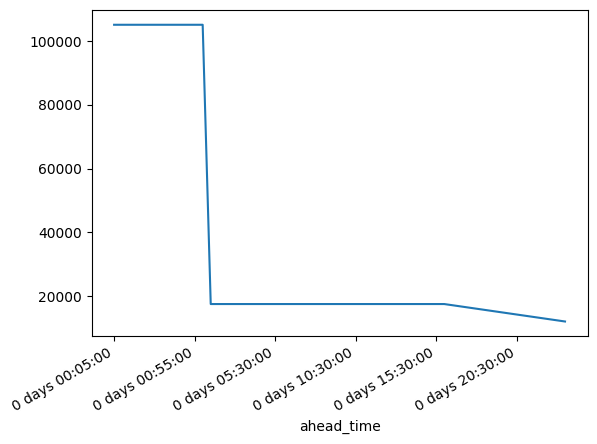

In [141]:
nsw_da.groupby("ahead_time").size().plot()

/tmp/ipykernel_1002894/4065977780.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(0.0, 300.0)

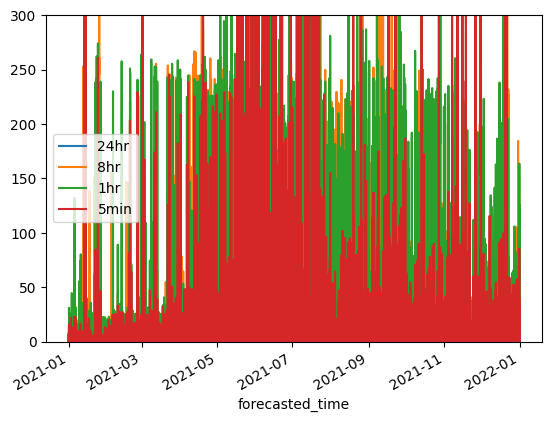

In [164]:
nsw_da.error = nsw_da.error.abs()
p = nsw_da[nsw_da.ahead_time == timedelta(hours=24)].plot(x="forecasted_time", y="error", label="24hr")
nsw_da[nsw_da.ahead_time == timedelta(hours=8)].plot(x="forecasted_time", y="error", label="8hr", ax=p)
nsw_da[nsw_da.ahead_time == timedelta(hours=1)].plot(x="forecasted_time", y="error", label="1hr", ax=p)
nsw_da[nsw_da.ahead_time == timedelta(minutes=5)].plot(x="forecasted_time", y="error", ax=p, label="5min")
p.set_ylim([0, 300])